In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch

In [3]:
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [4]:
RANDOM_SEED = 1
BATCH_SIZE = 100
NUM_EPOCHS = 100
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 52565003.43it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 2048183.11it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13800152.84it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3556857.50it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Image batch dimensions: torch.Size([100, 1, 28, 28])
Image label dimensions: torch.Size([100])


In [7]:
class MLP(torch.nn.Module):
  def __init__(self, num_features, num_hidden, num_classes):
    super().__init__()

    self.num_classes = num_classes

    # #1st hidden layer
    self.linear_1 = torch.nn.Linear(num_features, num_hidden)
    self.linear_1.weight.detach().normal_(0.0, 0.1)
    self.linear_1.bias.detach().zero_()

    #Output layer
    self.linear_out = torch.nn.Linear(num_features, num_classes)
    self.linear_out.weight.detach().normal_(0.0, 0.1)
    self.linear_out.bias.detach().zero_()

  def forward(self, x):
    out = self.linear_1(x)
    out = torch.sigmoid(out)
    logits = self.linear_out(out)
    # probas = torch.softmax(logits, dim=1)
    return logits#, probas

torch.manual_seed(RANDOM_SEED)
model = MLP(num_features = 28*28, num_hidden = 100, num_classes = 10).to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

#TRAINING

def compute_loss(net, data_loader):
  curr_loss=0.
  with torch.no_grad():
    for cnt, (features, targets) in enumerate(data_loader):
      features = features.view(-1, 28*28).to(DEVICE)
      targets = targets.to(DEVICE)
      logits, probas= net(features)
      loss = F.nll_loss(torch.log(probas), targets)

      curr_loss +=loss
    return float(curr_loss)/cnt


start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)

        ### FORWARD AND BACK PROP
        logits = model(features)

        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        minibatch_cost.append(cost.item())
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f'
                   %(epoch+1, NUM_EPOCHS, batch_idx,
                     len(train_loader), cost.item()))

    cost = compute_loss(model, train_loader)
    epoch_cost.append(cost)
    print('Epoch: %03d/%03d Train Cost: %.4f' % (
            epoch+1, NUM_EPOCHS, cost))
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x100 and 784x10)

In [8]:
class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden, num_classes):
        super().__init__()

        self.num_classes = num_classes

        ### 1st hidden layer
        self.linear_1 = torch.nn.Linear(num_features, num_hidden)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()

        ### Output layer
        self.linear_out = torch.nn.Linear(num_hidden, num_classes)
        self.linear_out.weight.detach().normal_(0.0, 0.1)
        self.linear_out.bias.detach().zero_()

    def forward(self, x):
        out = self.linear_1(x)
        out = torch.sigmoid(out)
        logits = self.linear_out(out)
        #probas = torch.softmax(logits, dim=1)
        return logits#, probas


#################################
### Model Initialization
#################################

torch.manual_seed(RANDOM_SEED)
model = MLP(num_features=28*28,
            num_hidden=100,
            num_classes=10)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

#################################
### Training
#################################

def compute_loss(net, data_loader):
    curr_loss = 0.
    with torch.no_grad():
        for cnt, (features, targets) in enumerate(data_loader):
            features = features.view(-1, 28*28).to(DEVICE)
            targets = targets.to(DEVICE)
            logits = net(features)
            loss = F.cross_entropy(logits, targets)
            curr_loss += loss
        return float(curr_loss)/cnt



start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)

        ### FORWARD AND BACK PROP
        logits = model(features)

        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        minibatch_cost.append(cost.item())
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f'
                   %(epoch+1, NUM_EPOCHS, batch_idx,
                     len(train_loader), cost.item()))

    cost = compute_loss(model, train_loader)
    epoch_cost.append(cost)
    print('Epoch: %03d/%03d Train Cost: %.4f' % (
            epoch+1, NUM_EPOCHS, cost))
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/100 | Batch 000/600 | Cost: 2.5604
Epoch: 001/100 | Batch 050/600 | Cost: 1.8231
Epoch: 001/100 | Batch 100/600 | Cost: 1.4972
Epoch: 001/100 | Batch 150/600 | Cost: 1.1972
Epoch: 001/100 | Batch 200/600 | Cost: 0.8770
Epoch: 001/100 | Batch 250/600 | Cost: 0.8388
Epoch: 001/100 | Batch 300/600 | Cost: 0.7779
Epoch: 001/100 | Batch 350/600 | Cost: 0.7459
Epoch: 001/100 | Batch 400/600 | Cost: 0.6769
Epoch: 001/100 | Batch 450/600 | Cost: 0.5171
Epoch: 001/100 | Batch 500/600 | Cost: 0.5568
Epoch: 001/100 | Batch 550/600 | Cost: 0.5620
Epoch: 001/100 Train Cost: 0.4960
Time elapsed: 0.29 min
Epoch: 002/100 | Batch 000/600 | Cost: 0.4814
Epoch: 002/100 | Batch 050/600 | Cost: 0.4956
Epoch: 002/100 | Batch 100/600 | Cost: 0.3412
Epoch: 002/100 | Batch 150/600 | Cost: 0.3469
Epoch: 002/100 | Batch 200/600 | Cost: 0.4675
Epoch: 002/100 | Batch 250/600 | Cost: 0.3761
Epoch: 002/100 | Batch 300/600 | Cost: 0.4029
Epoch: 002/100 | Batch 350/600 | Cost: 0.4599
Epoch: 002/100 | Batch 

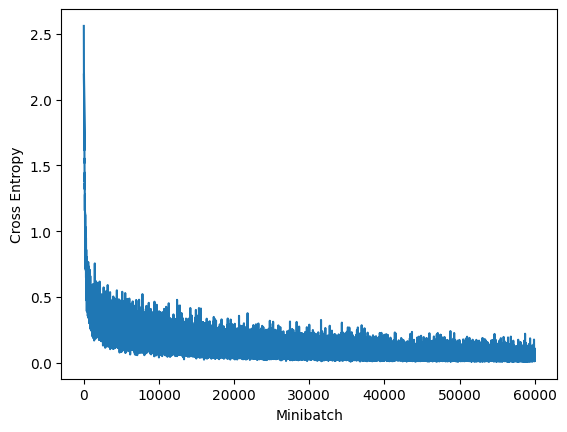

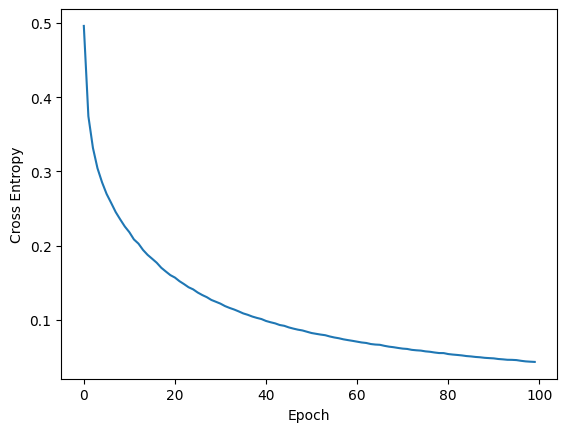

In [9]:
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [10]:
def compute_accuracy(net, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28).to(DEVICE)
            targets = targets.to(DEVICE)
            logits = net.forward(features)
            predicted_labels = torch.argmax(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100

print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Training Accuracy: 98.99
Test Accuracy: 97.68
